In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


from windrose import WindroseAxes
import seaborn as sns
import matplotlib as mpl

In [2]:
m = ['11', '12', '01', '02',]
station = 'Haukeliseter'
analysis_time =  '12' #'00'
meps_run = ['CTRL', 'ICE-T']

nc_dir = '/home/franzihe/Documents/Data/Weathermast_MEPS_Retrieval/'  #direction to save the final file

In [3]:
# plot cosmetics
sns.set_context('paper')

sns.set(font = 'Serif', font_scale = 1.2, )
sns.set_style('ticks', 
                  {'font.family':'serif', #'font.serif':'Helvetica'
                   'grid.linestyle': '--',
                   'axes.grid': True,
                  }, 
                   )
# Set the palette to the "pastel" default palette:
sns.set_palette("colorblind")

In [4]:
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m          = dict()
obs_wind_speed_10m        = dict()
obs_dofe_temp             = dict()



obs_westerly_idx = dict()
obs_easterly_idx = dict()

obs_westerly = dict()
obs_easterly = dict()

obs_diff      = dict()
obs_diff_2deg = dict()
obs_diff_2deg_west = dict()
obs_diff_2deg_east = dict()

obs = dict()

In [5]:
ret_diff_pulsed = dict()
ret_diff_upslope = dict()
swc_pulsed = dict()
swc_upslope = dict()

ret_diff_2deg = dict()
SWC = dict()
ret_diff_2deg_west = dict()
ret_diff_2deg_east = dict()

ret = dict()

In [6]:
eklima_diff = dict()
eklima_wind_dir_10m = dict()
eklima_wind_speed_10m = dict()
eklima_dofe_temp = dict()


eklima_westerly = dict()
eklima_easterly = dict()

eklima_diff_2deg = dict()

In [7]:
def wind_assignment_lower_10min(obs_westerly_idx, obs_easterly_idx):
        sub_idx = []   # locates the ending of the westerly burst
        for i in range(obs_westerly_idx.shape[0] -1):
            if obs_westerly_idx[i] + 1  == obs_westerly_idx[i+1]:
                continue
            else:
                sub_idx.append(i)
        sub_idx = np.asarray(sub_idx)
        
        _ww = []
        ## find westerlies which are < 10 min and assign them to obs_easterly wind regime
        if len(obs_westerly_idx) == 0 and len(sub_idx) == 0: # if there are only easterlies create empty westerly array
            obs_westerly = pd.DataFrame()
            
            if len(obs_easterly_idx) == 0:
                obs_easterly =  pd.DataFrame()
            else:
                obs_easterly = pd.DataFrame(obs_easterly_idx[:])

        elif len(obs_westerly_idx) != 0 and len(sub_idx) == 0:
            _ww = []
            obs_westerly = pd.DataFrame()
            
            if len(obs_easterly_idx) == 0:
                obs_easterly = pd.DataFrame()
            else:
                obs_easterly = pd.DataFrame(obs_easterly_idx[:])
            _west_duration = obs_westerly_idx[-1] - obs_westerly_idx[0]
            
            _ww.append(_west_duration)
            if _west_duration >= 10:  # adjusted from 28 to 10, becuase we only look at the lower 300 m with an assumed fallspeed of 1m/s and have a buffer we choose 10 min (without buffer 5min)
                obs_westerly = pd.concat([obs_westerly,
                                          pd.DataFrame(obs_westerly_idx[:])])
            elif _west_duration < 9: # adjusted from 28 to 10
                obs_easterly = pd.concat([obs_easterly,
                                          pd.DataFrame(obs_westerly_idx[:])])

        elif len(obs_westerly_idx) != 0 and len(sub_idx) !=0:
            obs_westerly = pd.DataFrame()#obs_westerly_idx)
            obs_easterly = pd.DataFrame(obs_easterly_idx)
            _ww = []
            for i in range(sub_idx.shape[0]+1):
                # calculate the durations,
                if i == 0:
                    _west_duration = obs_westerly_idx[sub_idx[i]] - \
                                     obs_westerly_idx[i]  # when at the beginning take the first sub index which locates the end of the westerly burst
                elif i == sub_idx.shape[0]:
                    _west_duration = obs_westerly_idx[-1] - \
                                     obs_westerly_idx[sub_idx[-1]+1] # when at the end take the last starting point of the westerly burst and subtract it from the last entry in the idx
                else:
                    _west_duration = obs_westerly_idx[sub_idx[i]] - \
                                     obs_westerly_idx[sub_idx[i-1]+1]  # any other time, take the ending of the westerly burst and subtract the starting of the westerly burst
                _ww.append(_west_duration)
                
                if _west_duration >= 10:
                    if i == 0:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[i : sub_idx[0]+1])])
                    elif i == sub_idx.shape[0]:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[sub_idx.shape[0]-1]+1:])])
                    else:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[i-1]+1 : sub_idx[i]+1])])
                elif _west_duration < 10:
                #    print(Date, _west_duration)
                    if i == 0:
                        obs_easterly = pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[i : sub_idx[i]+1])])
                    elif i == sub_idx.shape[0]:
                        obs_easterly =  pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[sub_idx.shape[0]-1]+1:])])
                    else:
                        obs_easterly = pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[i-1]+1 : sub_idx[i]+1])])

                
                
 #       print(_ww)  
        if len(obs_westerly) != 0:
            obs_westerly = obs_westerly.sort_values(0, axis = 0, ascending = True, ignore_index = True)
        elif len(obs_easterly) != 0:
            obs_easterly = obs_easterly.sort_values(0, axis = 0, ascending = True, ignore_index = True)

        return(obs_westerly, obs_easterly)

In [8]:
date = []

In [9]:
for month in m:
    if month == '11':
        t = np.arange(29,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        Date = int(year+month+day)
        ## Minuelty observations
        obs_dirnc = '/home/franzihe/Documents/Data/Weathermast/%s/CTRL_ICE-T/Met_%s_%s_%s.nc' %(station,Date,analysis_time,station)
        obs_f = xr.open_dataset(obs_dirnc)
        obs_f = obs_f.assign_coords(time = np.arange(0,1440), accum = np.arange(0,3))

        obs_double_fence_acc_mean[Date] = obs_f.double_fence_accum.mean(axis = 1, skipna = True)
        obs_wind_dir_10m[Date]   = obs_f['10m_wind_dir_mast1']
        obs_wind_speed_10m[Date] = obs_f['10m_wind_speed_mast1']
        obs_dofe_temp[Date]      = obs_f['air_temp']

#        # Calculate the moving average. That is, take
 #               # the first ten values, average them, 
  #              # then drop the first and add the eleventh, etc.
   #             # precipitation 
    #    if month != 11 and day == '01':
     #       if month == '12':
      #          previous_day = 20161130
       #     elif month == '01':
        #        previous_day = 20161231
         #   elif month == '02':
          #      previous_day = 20170131
#        else:
 #           previous_day = Date-1
  #      if Date == int(20161129):
   #         continue
    #    else:
     #       obs_dofe_acc_rolling = xr.concat([obs_double_fence_acc_mean[previous_day][-9:], 
      #                                              obs_double_fence_acc_mean[Date][:]], dim = 'time').rolling(time = 10,
       #                                                                                                  min_periods = 7,
        #                                                                                                 keep_attrs = True,
         #                                                                                                 ).mean()[9:,]
          #                                                                                                    
           #                                                                                                   
            #                                                                                                 
#            obs_wind_dir_rolling[Date] = xr.concat([obs_wind_dir_10m[previous_day][-9:],
 #                                                   obs_wind_dir_10m[Date][:]], dim = 'time').rolling(time = 10,
  #                                                                                                    min_periods = 7,
   #                                                                                                   keep_attrs = True,
    #                                                                                                  center = True,
     #                                                                                                ).mean()[9:,]
#
 #           obs_wind_speed_rolling[Date] = xr.concat([obs_wind_speed_10m[previous_day][-9:], 
  #                                                    obs_wind_speed_10m[Date][:]], dim = 'time').rolling(time = 10,
   #                                                                                                       min_periods = 7,
    #                                                                                                      keep_attrs = True,
     #                                                                                                    ).mean()[9:,]
#
 #           obs_air_temp_rolling[Date] = xr.concat([obs_dofe_temp[previous_day][-9:], 
  #                                                  obs_dofe_temp[Date][:]], dim = 'time').rolling(time = 10,
   #                                                                                                min_periods = 7,
    #                                                                                               keep_attrs = True,
     #                                                                                             ).mean()[9:,]
      #      
            

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[Date]    = np.empty(shape = obs_double_fence_acc_mean[Date].shape)
        obs_diff[Date][:] = np.nan

        for i in range(obs_double_fence_acc_mean[Date].shape[0]-1):
                obs_diff[Date][int(i),] = obs_double_fence_acc_mean[Date][int(i)+1] - \
                                          obs_double_fence_acc_mean[Date][int(i)]

        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_double_fence_acc_mean[Date].shape[0])

        ## find all obs_westerly regimes (202.5 - 22.5 deg)
        obs_westerly_idx[Date] = IDX[np.logical_or(np.logical_and(obs_wind_dir_10m[Date][:,] >= 202.5 ,
                                                                  obs_wind_dir_10m[Date][:,] <= 360.),
                                    obs_wind_dir_10m[Date][:,] < 22.5)]

        ## find all obs_easterly regimes (22.5 - 202.5 deg)
        obs_easterly_idx[Date] = IDX[np.logical_and(obs_wind_dir_10m[Date][:,] >= 22.5,
                                                    obs_wind_dir_10m[Date][:,] < 202.5)]


        
        # find when westerly is < 10 min within an easterly wind and assign it to easterly
        obs_westerly[Date], obs_easterly[Date]  = wind_assignment_lower_10min(obs_westerly_idx[Date], 
                                                                              obs_easterly_idx[Date])

        
        
        
        if len(obs_easterly[Date]) == 0 or len(obs_westerly[Date]) == 0:
            print(Date, 'only one direction')
            
           # continue
#        if len(obs_westerly[Date]) == 0:
           # continue
  #          print(Date, 'only easterly')
        else:
            obs_westerly[Date] = obs_westerly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
            obs_easterly[Date] = obs_easterly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
            # find when easterly is < 10 min within a westerly wind and assign it to westerly
            obs_easterly[Date], obs_westerly[Date]  = wind_assignment_lower_10min(obs_easterly[Date][0].to_numpy(), 
                                                                              obs_westerly[Date][0].to_numpy(), )
        if len(obs_westerly[Date]) != 0:
                obs_westerly[Date] = obs_westerly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
                obs_westerly[Date] = obs_westerly[Date].rename(columns = {0:'westerly_idx'},)
                obs_westerly[Date] = obs_westerly[Date].astype('int64')
        if len(obs_easterly[Date]) != 0:
                obs_easterly[Date] = obs_easterly[Date].sort_values(0, axis = 0, ascending = True, ignore_index = True)
                obs_easterly[Date] = obs_easterly[Date].rename(columns = {0:'easterly_idx'}, )
                obs_easterly[Date] = obs_easterly[Date].astype('int64')
        
        
        #### assign nan values where air temperature is larger than 2 degC
        obs_diff_2deg[Date] = pd.DataFrame(obs_diff[Date])
        filter = obs_dofe_temp[Date].to_dataframe()['air_temp'] <= 2.
        obs_diff_2deg[Date].where(filter,inplace = True, other = np.nan)
        obs_diff_2deg[Date].rename(columns = {0:'precip_diff_2deg'}, inplace = True)

        
        
        obs_f.close()
        # Retrieval data: assign OESR depending on the wind direction

        ret_dirnc = '/home/franzihe/Documents/Data/Retrieval/%s/minute_surface_acc/CTRL_ICE-T/%s_%s.nc' %(station,Date,analysis_time)
        
        try:
            ret_f = xr.open_dataset(ret_dirnc)
        except OSError:
            print(Date, 'no retrieval data')

        else:
            ret_f = ret_f.assign_coords(time = np.arange(0,1440), )
            ret_diff_pulsed[Date] = ret_f['pulsed_sfc_acc']
            ret_diff_upslope[Date] = ret_f['upslope_sfc_acc']
            swc_pulsed[Date] = ret_f['pulsed_SWC']
            swc_upslope[Date] = ret_f['upslope_SWC']

            if len(obs_westerly[Date]) ==  len(ret_diff_pulsed[Date]): #only westerlies, use retrieval for westerlies
                ret_diff_2deg[Date] = ret_diff_pulsed[Date].to_dataframe()
                ret_diff_2deg[Date] = ret_diff_2deg[Date].rename(columns = {'pulsed_sfc_acc':'precip_diff_2deg'})
                
                
                ret_diff_2deg_west[Date] = ret_diff_pulsed[Date].to_dataframe()
                ret_diff_2deg_west[Date] = ret_diff_2deg_west[Date].rename(columns = {'pulsed_sfc_acc':'precip_diff_2deg'})
                
                obs_diff_2deg_west[Date] = obs_diff_2deg[Date][:]
                
                ret_diff_2deg_east[Date] = np.empty(shape = 1440)
                ret_diff_2deg_east[Date][:] =  np.nan
                ret_diff_2deg_east[Date] =  pd.DataFrame(ret_diff_2deg_east[Date])
                
                obs_diff_2deg_east[Date] = np.empty(shape = 1440)
                obs_diff_2deg_east[Date][:] = np.nan
                obs_diff_2deg_east[Date] = pd.DataFrame(obs_diff_2deg_east[Date])
                
                SWC[Date] =  swc_pulsed[Date].to_dataframe()
            elif len(obs_easterly[Date]) == len(ret_diff_upslope[Date]): #only easterlies, use retrieval for easterlies
                ret_diff_2deg[Date] = ret_diff_upslope[Date].to_dataframe()
                ret_diff_2deg[Date] = ret_diff_2deg[Date].rename(columns = {'upslope_sfc_acc':'precip_diff_2deg'})
                
                ret_diff_2deg_east[Date] = ret_diff_upslope[Date].to_dataframe()
                ret_diff_2deg_east[Date] = ret_diff_2deg_east[Date].rename(columns = {'upslope_sfc_acc':'precip_diff_2deg'})
                
                obs_diff_2deg_east[Date] = obs_diff_2deg[Date][:]
                
                ret_diff_2deg_west[Date] = np.empty(shape = 1440)
                ret_diff_2deg_west[Date][:] =  np.nan
                ret_diff_2deg_west[Date] = pd.DataFrame(ret_diff_2deg_west[Date])
                
                
                obs_diff_2deg_west[Date] = np.empty(shape = 1440)
                obs_diff_2deg_west[Date][:] =  np.nan
                obs_diff_2deg_west[Date] = pd.DataFrame(obs_diff_2deg_west[Date])
                
                
                SWC[Date] = swc_upslope[Date].to_dataframe()

            elif len(obs_westerly[Date]) + len(obs_easterly[Date]) == len(ret_diff_pulsed[Date]) and \
                 len(obs_westerly[Date]) + len(obs_easterly[Date]) == len(ret_diff_upslope[Date]): #both wind directions exist
                ret_diff_2deg[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                ret_diff_2deg[Date][:] = np.nan
                ret_diff_2deg[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = ret_diff_pulsed[Date][np.asarray(obs_westerly[Date]['westerly_idx'])]
                ret_diff_2deg[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = ret_diff_upslope[Date][np.asarray(obs_easterly[Date]['easterly_idx'])]
                ret_diff_2deg[Date] = pd.DataFrame(ret_diff_2deg[Date])
                
                ret_diff_2deg_west[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                ret_diff_2deg_west[Date][:] = np.nan
                ret_diff_2deg_west[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = ret_diff_pulsed[Date][np.asarray(obs_westerly[Date]['westerly_idx'])]
                ret_diff_2deg_west[Date] = pd.DataFrame(ret_diff_2deg_west[Date])
                
                obs_diff_2deg_west[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                obs_diff_2deg_west[Date][:] = np.nan
                obs_diff_2deg_west[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = obs_diff_2deg[Date]['precip_diff_2deg'][np.asarray(obs_westerly[Date]['westerly_idx'])]
                obs_diff_2deg_west[Date] = pd.DataFrame(obs_diff_2deg_west[Date])

                ret_diff_2deg_east[Date] = np.empty(shape = len(obs_westerly[Date]) + len(obs_easterly[Date]))
                ret_diff_2deg_east[Date][:] = np.nan
                ret_diff_2deg_east[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = ret_diff_upslope[Date][np.asarray(obs_easterly[Date]['easterly_idx'])]
                ret_diff_2deg_east[Date] = pd.DataFrame(ret_diff_2deg_east[Date])
                
                obs_diff_2deg_east[Date] = np.empty(shape = len(obs_westerly[Date]) +  len(obs_easterly[Date]))
                obs_diff_2deg_east[Date][:] = np.nan
                obs_diff_2deg_east[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = obs_diff_2deg[Date]['precip_diff_2deg'][np.asarray(obs_easterly[Date]['easterly_idx'])]
                obs_diff_2deg_east[Date] = pd.DataFrame(obs_diff_2deg_east[Date])
                
                if ret_diff_2deg[Date].columns == 'pulsed_sfc_acc':
                    ret_diff_2deg[Date].rename(columns = {'pulsed_sfc_acc':'precip_diff_2deg'}, inplace = True)
                if ret_diff_2deg[Date].columns == 'upslope_sfc_acc':
                    ret_diff_2deg[Date].rename(columns = {'upslope_sfc_acc':'precip_diff_2deg'}, inplace = True)
                if ret_diff_2deg[Date].columns == 0:
                    ret_diff_2deg[Date].rename(columns = {0:'precip_diff_2deg'}, inplace = True)
                

                SWC[Date] = np.empty(shape = (len(obs_westerly[Date]) + len(obs_easterly[Date]), 14))
                SWC[Date][:] = np.nan
                SWC[Date][np.asarray(obs_westerly[Date]['westerly_idx'])] = swc_pulsed[Date][np.asarray(obs_westerly[Date]['westerly_idx'])]
                SWC[Date][np.asarray(obs_easterly[Date]['easterly_idx'])] = swc_upslope[Date][np.asarray(obs_easterly[Date]['easterly_idx'])]
                SWC[Date] = pd.DataFrame(SWC[Date])
                
                
            if len(obs_westerly[Date]) + len(obs_easterly[Date]) == 1440:
                if obs_diff_2deg[Date].sum()['precip_diff_2deg'] >= 0.25 and ret_diff_2deg[Date].sum()['precip_diff_2deg'] >= 0.25 :
                    print(Date)
                    date.append(Date)
                    
            ret_f.close()

20161129 only one direction
20161129
20161130 only one direction
20161201 only one direction
20161202 only one direction
20161203 only one direction
20161204 only one direction
20161208 only one direction
20161208
20161209
20161210 only one direction
20161210
20161212
20161215
20161216 no retrieval data
20161217 no retrieval data
20161218 no retrieval data
20161220 only one direction
20161220
20161221
20161222
20161223
20161224 only one direction
20161224
20161225 only one direction
20161225
20161226 only one direction
20161226
20161229
20161230 only one direction
20161231 only one direction
20161231
20170102
20170103 only one direction
20170103
20170105
20170106
20170108
20170109 only one direction
20170109
20170110
20170111 only one direction
20170111
20170112
20170118 only one direction
20170119 only one direction
20170122 only one direction
20170124 only one direction
20170128
20170129 no retrieval data
20170130 no retrieval data
20170131 no retrieval data
20170201 only one directi

In [10]:
obs = dict()


obs['WD'] = pd.DataFrame()
obs['WS'] = pd.DataFrame()
obs['precip'] = pd.DataFrame()
obs['precip_west'] = pd.DataFrame()
obs['precip_east'] =  pd.DataFrame()
obs['2T'] = pd.DataFrame()
obs['westerly_idx'] = pd.DataFrame()
obs['easterly_idx'] = pd.DataFrame()

In [11]:
for Date in date[1:]:
    obs['WD'] = pd.concat([obs['WD'], 
                           obs_wind_dir_10m[Date].to_dataframe().rename(columns = {'10m_wind_dir_mast1':Date})], axis = 1)
    
    obs['WS'] = pd.concat([obs['WS'],
                           obs_wind_speed_10m[Date].to_dataframe().rename(columns = {'10m_wind_speed_mast1':Date})], axis = 1)
    obs['precip'] = pd.concat([obs['precip'],
                           obs_diff_2deg[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
    if obs_diff_2deg_west[Date].columns == 0:
        obs['precip_west'] = pd.concat([obs['precip_west'],
                                    obs_diff_2deg_west[Date].rename(columns = {0:Date})], axis = 1)
    if obs_diff_2deg_west[Date].columns == 'precip_diff_2deg':
        obs['precip_west'] = pd.concat([obs['precip_west'],
                                    obs_diff_2deg_west[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
    if obs_diff_2deg_east[Date].columns == 0:
        obs['precip_east'] = pd.concat([obs['precip_east'],
                                    obs_diff_2deg_east[Date].rename(columns = {0:Date})], axis = 1)
    if obs_diff_2deg_east[Date].columns == 'precip_diff_2deg':
        obs['precip_east'] = pd.concat([obs['precip_east'],
                                    obs_diff_2deg_east[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
    
    
    obs['2T'] = pd.concat([obs['2T'],
                           obs_dofe_temp[Date].to_dataframe().rename(columns = {'air_temp':Date})], axis = 1)
    if obs_westerly[Date].columns == 'westerly_idx':
        obs['westerly_idx'] = pd.concat([obs['westerly_idx'],
                                     obs_westerly[Date].rename(columns = {'westerly_idx': Date})], axis = 1)
    if obs_westerly[Date].columns == 0:
        obs['westerly_idx'] = pd.concat([obs['westerly_idx'],
                                         obs_westerly[Date].rename(columns = {0: Date})], axis = 1)
    if obs_easterly[Date].columns == 'easterly_idx':
        obs['easterly_idx'] = pd.concat([obs['easterly_idx'],
                                     obs_westerly[Date].rename(columns = {'easterly_idx': Date})], axis = 1)
    if obs_easterly[Date].columns == 0:
        obs['easterly_idx'] = pd.concat([obs['easterly_idx'],
                                         obs_easterly[Date].rename(columns = {0: Date})], axis = 1)

In [12]:
ret['WD'] = pd.DataFrame()
ret['WS'] = pd.DataFrame()
ret['precip'] = pd.DataFrame()
ret['precip_west'] = pd.DataFrame()
ret['precip_east'] = pd.DataFrame()
ret['2T'] = pd.DataFrame()
ret['westerly_idx'] = pd.DataFrame()
ret['easterly_idx'] = pd.DataFrame()

In [13]:
for Date in date[1:]:
    ret['WD'] = pd.concat([ret['WD'], 
                           obs_wind_dir_10m[Date].to_dataframe().rename(columns = {'10m_wind_dir_mast1':Date})], axis = 1)
    
    ret['WS'] = pd.concat([ret['WS'],
                           obs_wind_speed_10m[Date].to_dataframe().rename(columns = {'10m_wind_speed_mast1':Date})], axis = 1)
    
    
    ret['precip'] = pd.concat([ret['precip'],
                           ret_diff_2deg[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
    if ret_diff_2deg_west[Date].columns == 0:
        ret['precip_west'] = pd.concat([ret['precip_west'],
                           ret_diff_2deg_west[Date].rename(columns = {0:Date})], axis = 1)
    if ret_diff_2deg_west[Date].columns == 'precip_diff_2deg':
        ret['precip_west'] = pd.concat([ret['precip_west'],
                           ret_diff_2deg_west[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)
    if ret_diff_2deg_east[Date].columns == 0:
        ret['precip_east'] = pd.concat([ret['precip_east'],
                           ret_diff_2deg_east[Date].rename(columns = {0:Date})], axis = 1)
    if ret_diff_2deg_east[Date].columns == 'precip_diff_2deg':
        ret['precip_east'] = pd.concat([ret['precip_east'],
                           ret_diff_2deg_east[Date].rename(columns = {'precip_diff_2deg':Date})], axis = 1)


    
    ret['2T'] = pd.concat([ret['2T'],
                           obs_dofe_temp[Date].to_dataframe().rename(columns = {'air_temp':Date})], axis = 1)
    if obs_westerly[Date].columns == 'westerly_idx':
        ret['westerly_idx'] = pd.concat([ret['westerly_idx'],
                                     obs_westerly[Date].rename(columns = {'westerly_idx': Date})], axis = 1)
    if obs_westerly[Date].columns == 0:
        ret['westerly_idx'] = pd.concat([ret['westerly_idx'],
                                         obs_westerly[Date].rename(columns = {0: Date})], axis = 1)
    if obs_easterly[Date].columns == 'easterly_idx':
        ret['easterly_idx'] = pd.concat([ret['easterly_idx'],
                                     obs_westerly[Date].rename(columns = {'easterly_idx': Date})], axis = 1)
    if obs_easterly[Date].columns == 0:
        ret['easterly_idx'] = pd.concat([ret['easterly_idx'],
                                         obs_easterly[Date].rename(columns = {0: Date})], axis = 1)

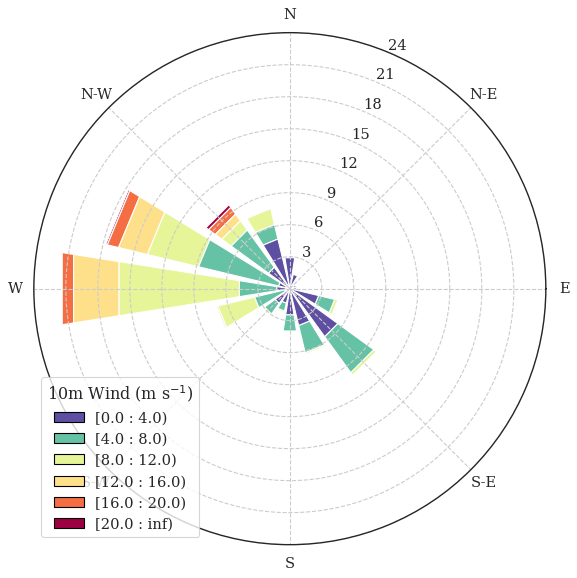

In [14]:
### Plot wind rose precipitation events

ax = WindroseAxes.from_ax()
ax.bar(obs['WD'][::60].values.flatten(), obs['WS'][::60].values.flatten(),
       normed = True, opening = 0.8, edgecolor = 'white', cmap = plt.get_cmap('Spectral_r', 6),
       bins = np.arange(0,24,4))
ax._info['bins']
ax.set_legend()
ax.legend(title = '10m Wind (m s$^{-1}$)')
ax.set_yticks(np.arange(3,27, step = 3))
ax.set_yticklabels(np.arange(3, 27, step = 3));

In [51]:
obs['precip_west_hourly'] = obs['precip_west'].groupby(obs['precip_west'].index // 60).sum()
ret['precip_west_hourly'] = ret['precip_west'].groupby(ret['precip_west'].index // 60).sum()

In [124]:
obs['precip_east_hourly'] = obs['precip_east'].groupby(obs['precip_east'].index // 60).sum()
ret['precip_east_hourly'] = ret['precip_east'].groupby(ret['precip_east'].index // 60).sum()

In [94]:
from scipy.stats import linregress

In [189]:
def plt_observation(axs, x, y,regime,  _range, vmax=None):
    cmap = plt.get_cmap('Spectral_r', 26)

    counts, xedges, yedges, im = axs.hist2d(x,y, 
                                           bins = 20, 
                                          range = _range, 
                                           cmap = cmap,
                                           cmin=0.00000000001,
                                           norm = mpl.colors.Normalize(vmax = vmax)
                                           )
    
    _mask = (~np.isnan(y) & ~np.isnan(x))
    _x = np.linspace(0,5.1,20)
    _y = _x*linregress(x[_mask],y[_mask]).slope + linregress(x[_mask], y[_mask]).intercept
    
    annotation_string = r"""    {:}
    y = {:.2f}*x + {:.2f}
    R$^2$: {:.2f}
    """.format(regime,linregress(x[_mask],y[_mask]).slope, 
               linregress(x[_mask],y[_mask]).intercept, 
               linregress(x[_mask],y[_mask]).rvalue**2, )
    print('counts',counts, 'sum',np.nansum(counts),'shape', counts.shape, np.nanmax(counts))
    return(annotation_string, im)

counts [[121.   8.   3.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ 12.  18.  13.   2.   2.   2.  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [  4.   7.   6.   8.   4.   3.  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [  1.   1.   5.   1.   6.   4.   1.   1.   1.  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [  2.   1.  nan   1.   1.   4.   1.   4.  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [  1.  nan   1.   1.   1.   2.   1.  nan   1.   1.  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [  1.  nan  nan   1.  nan   1.   3.   1.  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [  1.  nan  nan  nan   1.  nan   4.  nan  nan  nan  nan   1.  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan   1.  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  

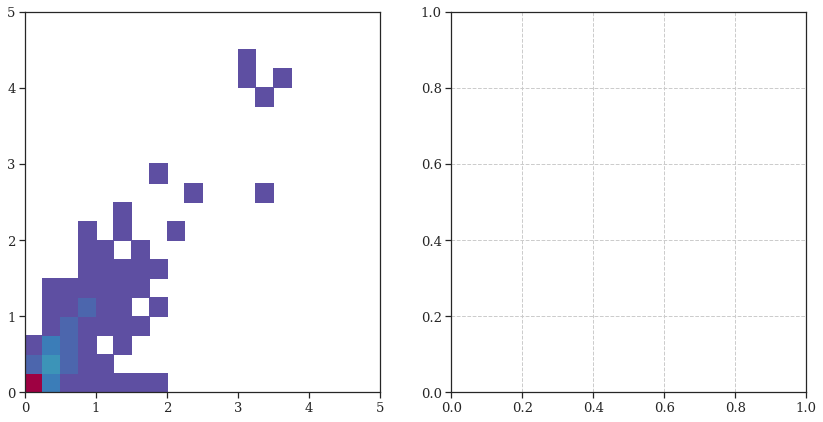

In [192]:
fig, axsm = plt.subplots(1, 2, figsize = [14,7])
axs = axsm.flatten()



vmax = 10

annotation_string = dict()
# West
filter = np.logical_and(obs['precip_west_hourly'] != 0.,
               ret['precip_west_hourly'] != 0.)
annotation_string[0],im = plt_observation(axs[0], 
                                      obs['precip_west_hourly'].where(filter, ).values.flatten(),
                                      ret['precip_west_hourly'].where(filter, ).values.flatten(), 
                                      'West',
                                          _range=[[0,5], [0,5]],
                                       vmax=121)

In [204]:
obs['precip_east_hourly'].where(filter, ).values.flatten().shape

(648,)

In [205]:
obs['precip_west_hourly'].where(filter, ).values.flatten().shape

(648,)

counts [[64.  4.  3. nan nan  1. nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 4.  8.  9.  3.  1.  1. nan nan  1. nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan  4.  1.  2.  3.  2. nan nan nan  1. nan nan nan nan nan nan nan nan
  nan nan]
 [nan  1.  1.  1. nan  4.  1. nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan  1. nan  1. nan nan nan nan  1. nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan  1.  1. nan nan  1. nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan  1. nan  1. nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan  1. nan nan nan nan nan nan nan
  nan nan]
 [nan  1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan  1. nan nan nan nan nan nan  1. nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan  1. nan nan nan nan nan nan nan
  nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan  1. nan nan 

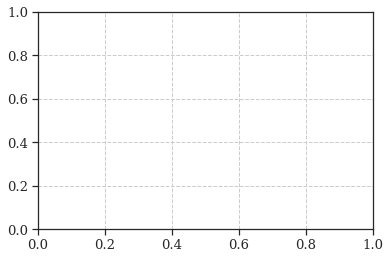

In [208]:
# East
filter = np.logical_and(obs['precip_east_hourly'] != 0.,
               ret['precip_east_hourly'] != 0.)
annotation_string[1], im = plt_observation(axs[0], 
                                      obs['precip_east_hourly'].where(filter, ).values.flatten(),
                                        ret['precip_east_hourly'].where(filter, ).values.flatten(), 
                                      'east',
                                           _range=[[0,4], [0,4]],
                                          vmax=27)

for i in range(len(axs)):
#    axs[i].set_aspect('equal')
    axs[i].set_xlabel('DFAR (mm h$^{-1}$)')
    axs[i].set_ylabel('OESR (mm h$^{-1}$)')
    axs[i].plot([0,1], [0,1], transform = axs[i].transAxes, color = 'grey', ls = '--')
    axs[i].plot(_x, _y, 'r', linewidth = '2')
#    axs[i].annotate(annotation_string[i], xy=(0.05, 0.80), xycoords='axes fraction',
 #                                            backgroundcolor='w', )
    plt.colorbar(im, ax = axs[i], norm = mpl.colors.NoNorm, orientation = 'horizontal')
#plt.colorbar(im, ax=axsm[:2],  #ax = axsm.ravel().tolist(),# cax=cbar_ax, 
 #                   norm = mpl.colors.NoNorm, #location = 'bottom', 
  #                  orientation = 'horizontal')

ValueError: too many values to unpack (expected 2)

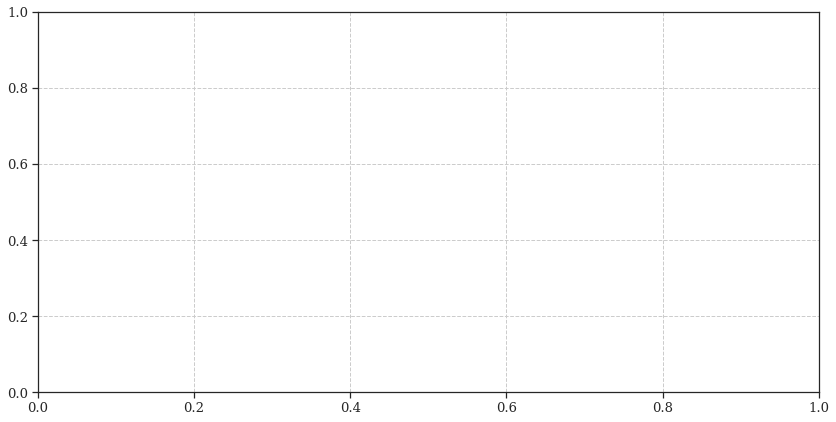

In [209]:
x = obs['precip_east_hourly'].where(filter, ).values.flatten(),
y = ret['precip_east_hourly'].where(filter, ).values.flatten(),

fig, axsm = plt.subplots(1, 1, figsize = [14,7])
#axs = axsm.flatten()


counts, xedges, yedges, im = axs[0].hist2d(x,y, 
                                           bins = 20, 
                                          range =[[0,4], [0,4]], 
                                     #      cmap = cmap,
                                      #     cmin=0.00000000001,
                                       #    norm = mpl.colors.Normalize(vmax = vmax)
                                           )

In [ ]:
        # Eklima data
    
        ### assign eklima data where 24H precip(T<2deg) < 0 mm 
        if obs_diff_2deg[Date].sum()[0] < 0.:
            eklima_dirnc = '/home/franzihe/Documents/Data/Eklima/%s/CTRL_ICE-T/precip_wind_temp_%s_%s.nc' %(station,Date,analysis_time)
            eklima_f = xr.open_dataset(eklima_dirnc)
            eklima_f = eklima_f.assign_coords(time = np.arange(0,24), )



            eklima_diff[Date] = eklima_f.RR_1
            eklima_wind_dir_10m[Date] = eklima_f.DD
            eklima_wind_speed_10m[Date] = eklima_f.FF
            eklima_dofe_temp[Date] = eklima_f.TA

            # Find wind regimes and associated precip amount
            IDX = np.arange(eklima_diff[Date].shape[0])

            ## find all obs_westerly regimes (202.5 - 22.5 deg)
            eklima_westerly[Date] = IDX[np.logical_or(np.logical_and(eklima_wind_dir_10m[Date].values >= 202.5 ,
                                                                         eklima_wind_dir_10m[Date].values <= 360.),
                                                          eklima_wind_dir_10m[Date].values < 22.5)]

            ## find all obs_easterly regimes (22.5 - 202.5 deg)
            eklima_easterly[Date] = IDX[np.logical_and(eklima_wind_dir_10m[Date].values >= 22.5,
                                                        eklima_wind_dir_10m[Date].values < 202.5)]



            #### assign nan values where air temperature is larger than 2 degC
            eklima_diff_2deg[Date] = eklima_diff[Date].to_dataframe()['RR_1']
            filter = eklima_dofe_temp[Date].to_dataframe()['TA'] <= 2.
            eklima_diff_2deg[Date].where(filter,inplace = True, other = np.nan)

            obs_diff_2deg[Date] = pd.DataFrame(eklima_diff_2deg[Date][:])
            obs_westerly[Date] = pd.DataFrame(eklima_westerly[Date][:])
            obs_easterly[Date] = pd.DataFrame(eklima_easterly[Date][:])
            obs_wind_dir_10m[Date] = pd.DataFrame(eklima_wind_dir_10m[Date][:])
            obs_wind_speed_10m[Date] =  pd.DataFrame(eklima_wind_speed_10m[Date][:])
            obs_dofe_temp[Date] =  pd.DataFrame(eklima_dofe_temp[Date][:])

In [ ]:
for month in m:
    if month == '11':
        t = np.arange(30,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        Date = int(year+month+day)
        
        